In [3]:
import pandas as pd
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns


In [4]:
class get_data():
    def open_ascii(directory=None):
        f = open(directory,"r")
        lines = f.read()
        f.close()
        return lines
    def get_dataframe(line):
        #Inıtializing locations for target and fixation start and end range for later filtering. 
        fixation_start_x = 1180
        fixation_start_y = 520
        fixation_end_x = 1380
        fixation_end_y = 920
        target_start_y = 520
        target_end_y = 920
        right_target_start_x = 1480
        right_target_end_x = 1980
        left_target_start_x = 580
        left_target_end_x = 1080
        
        new_lines = []
        for line in lines.split("\n"): #After we open ascii file we are going through all the lines in the file.
            if line.startswith("MSG") or line.startswith("ESACC"): #Only selecting lines that starts with either "MSG" or "ESACC", which will give us information about saccades.
                line = line.strip() #Remove any unwanted white spaces.
                line = " ".join(line.split("\t")) #Split each line by "\t" to remove all unnecessary white spaces and join them together to form lines.
                new_lines.append(line) #Append each line to a list.
        
        #Create list for all important items we want to get
        start_x = []
        start_y = []
        end_x = []
        end_y = []
        amplitude= []
        duration = []
        saccade_start_time = []
        saccade_end_time = []
        peak_velocity = []
        start_time = []
        end_time = []
        reward = []
        location = []
        target_onset = []
        target_offset = []

        for line in new_lines: #Go through each line in the list
            line= line.strip()
            line = re.sub(' +', ' ', line) #Remove any white spaces if they exist.
            split_line = line.split(" ") #Split every line with white space and create a list.
            if split_line[2].startswith("gap_offset"): # If line startswith gap_offset(target_onset)
                if len(split_line) == 7:
                    location = split_line[-1]
                else:
                    location = np.nan
                start_time.append((split_line[1],split_line[5],location))#Store start time, location, and reward value. We are storing all these variables to later extract reward value and location based on start time.
            if split_line[2].startswith("poly_offset"): #  If line startswith poly_offset(target_offset)
                end_time.append(split_line[1]) #Store the target offset time.
            if split_line[0].startswith("ESACC"): # If line starts with ESACC, if any saccade initiated.
                saccade_start_time.append(split_line[2]) #Store saccade start.
                saccade_end_time.append(split_line[3]) #Store saccade end.
                duration.append(float(split_line[4])) #Store duration.
                start_x.append(split_line[5]) # Store saccade start x location.
                start_y.append(split_line[6]) #Store saccade start y location.
                end_x.append(split_line[7]) # Store saccade end x location.
                end_y.append(split_line[8]) # Store saccade end y location.
                amplitude.append(float(split_line[9])) # Store saccade amplitude.
                peak_velocity.append(split_line[-1]) # Store saccade peak velocity
            if split_line[2].startswith("gap_offset"): #If line starts with gap_offset(target onset),store the time of target onset.
                target_onset.append(int(split_line[1])) 
            if split_line[2].startswith("poly_offset"):
                target_offset.append(int(split_line[1])) #If line starts with poly_offset(target offset),store the time of target offset.

        #Get Saccade information that happens between target onset and offset
        
        amp = []
        dur = []
        pv = []
        targ_on = []
        targ_off = []
        for i in range(len(target_onset)):
            for line in new_lines:
                line= line.strip()
                line = re.sub(' +', ' ', line)
                split_line = line.split(" ")
                if split_line[0].startswith("ESACC") and target_onset[i]<int(split_line[2])<target_offset[i]:
                    #print(i,split_line)
                    amp.append((i,float(split_line[-2]))) #We both store value of amplitude and it's index. Index means in which trial it is initiated. 
                    dur.append((i,float(split_line[4]))) # We store it's index value, because later we want to choose first amplitude that is bigger than 2 degrees,
                    targ_on.append(target_onset[i])     # by removing all the values of amplitude that are smaller than 2 amplitude, we can easily get the first saccade by
                    targ_off.append(target_offset[i])   # removing all the duplicate values but only keeping the first duplicate value which is first saccade that is loger than 2 degrees. 
                    pv.append(float(split_line[-1]))
                    
        
        #Get information about saccades that are between target onset and target offset.
        new_saccade_list = []
        reward_list = []
        loc_list =[]
        for i in range(len(target_onset)):
            for k in range(len(saccade_start_time)):
                if start_time[i][0]<saccade_start_time[k]<end_time[i]: #If saccade initiated after target onset and ended before target offset we select them,
                        new_saccade_list.append(saccade_start_time[k]) # and store values about saccades, reward and location seperately. In this section we get rid of all saccades 
                        reward_list.append(start_time[i][1])           # that are not initiated between target onset and target offset.
                        loc_list.append(start_time[i][2])
        
        
        #Based on all the list we created we create a data frame.
        df = pd.DataFrame({"amplitude (deg)":amplitude})
        df["duration (ms)"] = duration
        df["saccade_start"] = saccade_start_time # (ms)
        df["saccade_end"] = saccade_end_time # (ms)
        df["start_x"] = start_x
        df["start_y"] = start_y
        df["end_x"] = end_x
        df["end_y"] = end_y
        #df["average velocity (deg/sec)"] = df["amplitude (deg)"]/((df["duration (ms)"])/1000)
        df = df[df["saccade_start"].isin(new_saccade_list)].reset_index(drop=True) # We remove all saccades that are not initiated between target onset and target offset.
        df["peak velocity (deg/sec)"] = pv
        df["location"] = reward_list
        df["condition"] = loc_list
        df["target_onset"] = targ_on
        df[["index","amplitude"]] = amp
        df["index"] = df["index"].apply(lambda x: int(x)) #Turn str values into integer values for later calculations.
        
        #final_df = df[df["duration (ms)"].isin(max_dur)].reset_index(drop=True) #Decide Which one you are gonna use for the final analysis.
        final_df = df

        #Because we extract data from text file they are in string format not number format so we turn them into float values
        # for later calculations.
        final_df.start_x = final_df.start_x.apply(lambda x: float(x)) 
        final_df.start_y = final_df.start_y.apply(lambda x: float(x))
        final_df.end_x = final_df.end_x.apply(lambda x: float(x))
        final_df.end_y = final_df.end_y.apply(lambda x: float(x))
        final_df["saccade_start"] = final_df["saccade_start"].apply(lambda x: int(x))


        #Reorder column names for ease of life
        column_names = ['index', 'amplitude',"target_onset", 'saccade_start', 'saccade_end', 'start_x',
        'start_y', 'end_x', 'end_y', "duration (ms)", "peak velocity (deg/sec)",
        'location', 'condition']
        final_df = final_df.reindex(columns=column_names)

        #Out of all saccades that are initiated between target onset and target offset, we select only that starts,
        # around fixation point. We store them in two different lists for x location and y location.
        new_start_x = []
        new_start_y = []
        for x,y in zip(final_df.start_x,final_df.start_y): #   Create a variable for all locations.
            if fixation_start_x<x<fixation_end_x and fixation_start_y<y<fixation_end_y: #1080,1480 ---- 620,820 #
                new_start_x.append(x)
                new_start_y.append(y)

        #Out of all saccades that are initiated between target onset and target offset, we select only that ends,
        # around target. We store them in two different lists for x location and y location.
        new_end_x = []
        new_end_y = []
        index = 0
        for x,y in zip(final_df.end_x,final_df.end_y):
            if final_df.location[index] == "600.0" and right_target_start_x<x<right_target_end_x and target_start_y<y<target_end_y: #1680,2080 --- 620,820
                new_end_x.append(x)
                new_end_y.append(y)
            if final_df.location[index] == "-600.0" and left_target_start_x<x<left_target_end_x and target_start_y<y<target_end_y: #480,880 --- 620,820
                new_end_x.append(x)
                new_end_y.append(y)
            
            index += 1

        
        #In this section we choose only first saccades that are bigger than 2 amplitude.
        amplitude_list = []
        for i in range(450): #Was 250 changed to 450 look it again.
            for k in range(final_df.shape[0]):
                if i == final_df["index"][k]: #Chechk the first saccade and look it is long enough.
                    amplitude_list.append(final_df["amplitude"][k])
        #final_df = final_df[final_df["amplitude"].isin(amplitude_list)].reset_index(drop=True) #This gives us all the values that is bgger than 2 amplitude.
        final_df.drop_duplicates(subset="index",keep="first",inplace=True) #We drop duplicates values  but only keeping the first one.
        final_df.reset_index(drop=True) # Resetting index.

        
        #Selecting only data points that starts and ends locations we specify on the top, if it is outside it will discarded.
        final_df = final_df[final_df["start_x"].isin(new_start_x)].reset_index(drop=True)
        final_df = final_df[final_df["start_y"].isin(new_start_y)].reset_index(drop=True)
        final_df = final_df[final_df["end_x"].isin(new_end_x)].reset_index(drop=True)
        final_df = final_df[final_df["end_y"].isin(new_end_y).reset_index(drop=True)]



        #First we fill empty data points in condition column with "No Reward", then we create a new column(reward) with empty values
        # based on target's location and the condition we enter reward values in reward column. 
        # If target appear in 600 location and condition is 1(Right side gives high reward), then entry for reward will High Reward,
        # if location -600, the entry will be Low Reward. If target appear in -600 location and condition is 0(Left side gives high reward), then entry for reward will High Reward,
        # if location 600, the entry will be Low Reward.  
        
        try:
            final_df.fillna("No Reward",inplace=True)
            final_df["reward"] = np.nan
            for i in range(final_df.shape[0]):
                if final_df.location[i] == "600.0" and final_df.condition[i] == "1":
                    final_df.reward[i] = "High Reward"
                elif final_df.location[i] == "-600.0" and final_df.condition[i] == "1":
                    final_df.reward[i] = "Low Reward"
                elif final_df.location[i] == "600.0" and final_df.condition[i] == "0":
                    final_df.reward[i] = "Low Reward"
                elif final_df.location[i] == "-600.0" and final_df.condition[i] == "0":
                    final_df.reward[i] = "High Reward"
                else:
                    final_df.reward[i] = "No reward"
        except:
            final_df.fillna("No Reward",inplace=True)
            final_df["reward"] = np.nan
            final_df = final_df.reset_index(drop=True)
            for i in range(final_df.shape[0]):
                if final_df.location[i] == "600.0" and final_df.condition[i] == "1":
                    final_df.reward[i] = "High Reward"
                elif final_df.location[i] == "-600.0" and final_df.condition[i] == "1":
                    final_df.reward[i] = "Low Reward"
                elif final_df.location[i] == "600.0" and final_df.condition[i] == "0":
                    final_df.reward[i] = "Low Reward"
                elif final_df.location[i] == "-600.0" and final_df.condition[i] == "0":
                    final_df.reward[i] = "High Reward"
                else:
                    final_df.reward[i] = "No reward"
        

        # Calculating Saccadic Reaction Time by subtracting saccade start time from target onset.
        final_df["SRT"] = final_df["saccade_start"] - final_df["target_onset"]
        # Classifying saccades based on their Saccadic Reaction Time.
        final_df["type"] = final_df["SRT"].apply(lambda x: "es" if 130>x>80 else ("ns" if x>=130 else "as"))

        final_df = final_df[final_df.SRT<500]
        final_df = final_df[final_df["duration (ms)"]<75].reset_index(drop=True)
        final_df["block"] = np.nan
        for i in range(len(final_df["index"])):
            if final_df["index"][i]<150:
                final_df["block"][i] = int(1)
            if 150<final_df["index"][i]<200:
                final_df["block"][i] = int(2)
            if 250<final_df["index"][i]<300:
                final_df["block"][i] = int(3)
            if 350<final_df["index"][i]<400:
                final_df["block"][i] = int(4)
            if 200<final_df["index"][i]<250:
                final_df["block"][i] = int(5)
            if 300<final_df["index"][i]<350:
                final_df["block"][i] = int(6)
            if 400<final_df["index"][i]<450:
                final_df["block"][i] = int(7)
        
        final_df = final_df[final_df["SRT"]>70]
        
        return final_df
    
    def export_data(data=None,name=None,directory=None):
        data.to_csv (rf'/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/{name}.csv', index = False, header=True)

    def line_plot(value=None,line=None,data=None):
        new_lines = []
        for line in lines.split("\n"):
                line = line.strip()
                line = " ".join(line.split("\t"))#Going through all the lines in the asc file and removing all the tab white spaces.
                new_lines.append(line)
        x_loc = []
        y_loc = []
        for number,line in enumerate(new_lines):
            line= line.strip()
            line = re.sub(' +', ' ', line)  #Remove any white spaces if they exist.
            split_line = line.split(" ")  #Split every line with white space and create a list.
            #Find index of start time and end time of saccades that are in the dataframe.
            if split_line[0].startswith(str(data.saccade_start[value])):
                start_point = number
            if split_line[0].startswith(str(data.saccade_end[value])):
                end_point = number

        #Go through all the lines, where the saccade starts based on it's index value and where it ends and store them
        #in a list to later draw the line plot.
        for line in new_lines[start_point:end_point]:
            line= line.strip()
            line = re.sub(' +', ' ', line)
            split_line = line.split(" ")
            x_loc.append(float(split_line[1]))
            y_loc.append(float(split_line[2]))
        text = "No reward"
        condition = data["condition"][value]

        plt.figure(figsize=(10,5)) #Create figure
        ax=plt.gca()                            # get the axis
        ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
        ax.xaxis.tick_top()                     # and move the X-Axis      
        ax.yaxis.set_ticks(np.arange(0, 16, 1)) # set y-ticks
        ax.yaxis.tick_left() 
        
        label = data["SRT"][value]
        label_amplitude = data["amplitude"][value]
        label_duration = data["duration (ms)"][value]
        
        #Speed of saccade for the legend.
        plt.plot([], [], ' ', label=f"SRT: {label} ms")
        plt.plot([],[],' ',label=f"Amplitude: {label_amplitude}")
        plt.plot([],[],' ',label=f"Duration {label_duration} ms")

        #Based on the target's location, draw the target. 
        if float(data.location[value]) == 600:
            plt.scatter(1880,720,marker="X",color="black",s=50,label="Target")
            #plt.scatter((1480,1480,1980,1980),(520,920,520,920)) 
            if data["condition"][value] == "1":
                text = "High Reward"
            if data["condition"][value] == "0":
                text = "Low Reward"
        
        else:
            plt.scatter(680,720,marker= "X",color="black",s=50,label="Target")
            #plt.scatter((580,580,1080,1080),(520,920,520,920))
            if data["condition"][value] == "0":
                text = "High Reward"
            if data["condition"][value] == "1":
                text = "Low Reward"
            
        
        #Plot eye movements between start and end points.
        plt.plot(x_loc,y_loc,"-.",color="lightcoral")
        #Set Title, No of saccade, condition(No reward,0,1), Reward Value
        plt.title(f"Plot of {value} saccade, condition: {condition}, reward: {text}")
        
        #plt.scatter((1180,1180,1380,1380),(520,920,520,920))
        #Plot Fixation points.
        plt.scatter(1280,720,marker="P",s=50,label="Fixation")
        #Plot start point and ent point.
        plt.scatter(float(final_data.start_x[value]),float(final_data.start_y[value]),color="purple",s=50,label="start")
        plt.scatter(float(final_data.end_x[value]),float(final_data.end_y[value]),color="navy",s=50,label="end")
        #Create xticks and y ticks.
        plt.xticks(np.arange(0,2560,500))
        plt.yticks(np.arange(0,1440,200))
        plt.legend()
        #Create background grid
        plt.grid(True, which='major', color='darkgrey', linestyle='-.')
        plt.show()
    
    def preprocess(final_data=None):
        #Getting mean and median values of SRT for all conditions.
        Q1srt,mediansrt,Q3srt= final_data.SRT.quantile([0.25,0.5,0.75])
        meansrt = final_data.SRT.mean()
        Q1srtno,mediansrtno,Q3srtno=final_data[final_data.reward=="No reward"].SRT.quantile([0.25,0.5,0.75])
        meansrtno = final_data[final_data.reward=="No reward"].SRT.mean()
        Q1srtlow,mediansrtlow,Q3srtlow=final_data[final_data.reward=="Low Reward"].SRT.quantile([0.25,0.5,0.75])
        meansrtlow = final_data[final_data.reward=="No reward"].SRT.mean()
        Q1srthigh,mediansrthigh,Q3srthigh=final_data[final_data.reward=="High Reward"].SRT.quantile([0.25,0.5,0.75])
        meansrthigh = final_data[final_data.reward=="No reward"].SRT.mean()
        #Getting mean and median values of duration for all conditions.
        Q1dur,mediandur,Q3dur= final_data["duration (ms)"].quantile([0.25,0.5,0.75])
        meandur = final_data["duration (ms)"].mean()
        Q1durno,mediandurno,Q3durno=final_data[final_data.reward=="No reward"]["duration (ms)"].quantile([0.25,0.5,0.75])
        meandurno = final_data[final_data.reward=="No reward"]["duration (ms)"].mean()
        Q1durlow,mediandurlow,Q3durlow=final_data[final_data.reward=="Low Reward"]["duration (ms)"].quantile([0.25,0.5,0.75])
        meandurlow = final_data[final_data.reward=="No reward"]["duration (ms)"].mean()
        Q1durhigh,mediandurhigh,Q3durhigh=final_data[final_data.reward=="High Reward"]["duration (ms)"].quantile([0.25,0.5,0.75])
        meandurhigh = final_data[final_data.reward=="No reward"]["duration (ms)"].mean()
        #Getting mean and median values of amplitude for all conditions.
        Q1amp,medianamp,Q3amp= final_data["amplitude"].quantile([0.25,0.5,0.75])
        meanamp = final_data["amplitude"].mean()
        Q1ampno,medianampno,Q3ampno=final_data[final_data.reward=="No reward"]["amplitude"].quantile([0.25,0.5,0.75])
        meanampno = final_data[final_data.reward=="No reward"]["amplitude"].mean()
        Q1amplow,medianamplow,Q3amplow=final_data[final_data.reward=="Low Reward"]["amplitude"].quantile([0.25,0.5,0.75])
        meanamplow = final_data[final_data.reward=="No reward"]["amplitude"].mean()
        Q1amphigh,medianamphigh,Q3amphigh=final_data[final_data.reward=="High Reward"]["amplitude"].quantile([0.25,0.5,0.75])
        meanamphigh = final_data[final_data.reward=="No reward"]["amplitude"].mean()
        #Getting standard deviation of SRT for all conditions.
        stdsrt = final_data.SRT.std()
        stdsrtno = final_data[final_data.reward=="No reward"].SRT.std()
        stdsrtlow= final_data[final_data.reward=="Low Reward"].SRT.std()
        stdsrthigh= final_data[final_data.reward=="High Reward"].SRT.std()
        #Getting standard deviation of duration for all conditions.        
        stddur = final_data["duration (ms)"].std()
        stddurno = final_data[final_data.reward=="No reward"]["duration (ms)"].std()
        stddurlow= final_data[final_data.reward=="Low Reward"]["duration (ms)"].std()
        stddurhigh= final_data[final_data.reward=="High Reward"]["duration (ms)"].std()
        #Getting standard deviation of amplitude for all conditions.        


        #Creating a dataframe for all values we want in preprocessed dataframe.
        data = pd.DataFrame({"Q1":Q1srt,"median":mediansrt,"Q3":Q3srt,"mean":meansrt,
        "Q1srtno":Q1srtno,"mediansrtno":mediansrtno,"Q3srtno":Q3srtno,"meansrtno":meansrtno,
        "Q1srtlow":Q1srtlow,"mediansrtlow":mediansrtlow,"Q3srtlow":Q3srtlow,"meansrtlow":meansrtlow,
        "Q1srthigh":Q1srthigh,"mediansrthigh":mediansrthigh,"Q3srthigh":Q3srthigh,"meansrthigh":meansrthigh,
        "Q1dur":Q1dur,"mediandur":mediandur,"Q3dur":Q3dur,"meandur":meandur,
        "Q1durno":Q1durno,"mediandurno":mediandurno,"Q3durno":Q3durno,"meandurno":meandurno,
        "Q1durlow":Q1durlow,"mediandurlow":mediandurlow,"Q3durlow":Q3durlow,"meandurlow":meandurlow,
        "Q1durhigh":Q1durhigh,"mediandurhigh":mediandurhigh,"Q3durhigh":Q3durhigh,"meandurhigh":meandurhigh,
        "Q1amp":Q1amp,"medianamp":medianamp,"Q3amp":Q3amp,"meanamp":meanamp,
        "Q1ampno":Q1ampno,"medianampno":medianampno,"Q3ampno":Q3ampno,"meanampno":meanampno,
        "Q1amplow":Q1amplow,"medianamplow":medianamplow,"Q3amplow":Q3amplow,"meanamplow":meanamplow,
        "Q1amphigh":Q1amphigh,"medianamphigh":medianamphigh,"Q3amphigh":Q3amphigh,"meanamphigh":meanamphigh,
        "stdsrt":stdsrt,"stdsrtno":stdsrtno,"stdsrtlow":stdsrtlow,"stdsrthigh":stdsrthigh,
        "stddur":stddur,"stddurno":stddurno,"stddurlow":stddurlow,"stddurhigh":stddurhigh,

        },index=np.arange(0,1))

        return data
    
    def append(data_to_add=None,main_data=None):
        #Concatanating(Joining) each dataframe to each other to get a full dataframe with all participants.
        main_data = main_data.append(data_to_add,ignore_index=True)

        return main_data


In [ ]:
#Reading and storing ascii file
lines = get_data.open_ascii("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/1.asc")
#Getting Dataframe from stored ascii file
final_data = get_data.get_dataframe(lines)
#Exporting Data
get_data.export_data(final_data,directory="/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/",name="b")

lines = get_data.open_ascii("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/2.asc")
final_data = get_data.get_dataframe(lines)
get_data.export_data(final_data,directory="/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/",name="c")

lines = get_data.open_ascii("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/3.asc")
final_data = get_data.get_dataframe(lines)
get_data.export_data(final_data,directory="/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/",name="e")

lines = get_data.open_ascii("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/4.asc")
final_data = get_data.get_dataframe(lines)
get_data.export_data(final_data,directory="/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/",name="h")

lines = get_data.open_ascii("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/5.asc")
final_data = get_data.get_dataframe(lines)
get_data.export_data(final_data,directory="/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/",name="n")

lines = get_data.open_ascii("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/6.asc")
final_data = get_data.get_dataframe(lines)
get_data.export_data(final_data,directory="/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/",name="s")

lines = get_data.open_ascii("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/7.asc")
final_data = get_data.get_dataframe(lines)
get_data.export_data(final_data,directory="/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/",name="t")

lines = get_data.open_ascii("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/8.asc")
final_data = get_data.get_dataframe(lines)
get_data.export_data(final_data,directory="/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/",name="y")

lines = get_data.open_ascii("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/9.asc")
final_data = get_data.get_dataframe(lines)
get_data.export_data(final_data,directory="/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/",name="n2")


In [ ]:
#With this way we can get all the datasets in a one big dataset for both analysis and visualization.
data = pd.read_csv("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/1.csv")
data1 = pd.read_csv("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/2.csv")
data2 = pd.read_csv("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/3.csv")
data3 = pd.read_csv("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/4.csv")
data4 = pd.read_csv("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/5.csv")
data5 = pd.read_csv("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/6.csv")
data6 = pd.read_csv("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/7.csv")
data7 = pd.read_csv("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/8.csv")
data8 = pd.read_csv("/Users/fatihdeniz/Desktop/Analisation/final data/experiment data/9.csv")

all_data = get_data.append([data2,data3,data4,data5,data6,data7,data8],main_data=data1)
all_data = all_data.reset_index(drop=True)

#In here we get all processed datasets together.
data = get_data.preprocess(data)
data1 = get_data.preprocess(data1)
data2 = get_data.preprocess(data2)
data3 = get_data.preprocess(data3)
data4 = get_data.preprocess(data4)
data5 = get_data.preprocess(data5)
data6 = get_data.preprocess(data6)
data7 = get_data.preprocess(data7)
data8 = get_data.preprocess(data8)


all_data_preprocessed = get_data.append([data1,data2,data3,data4,data5,data6,data7,data8],main_data=data)


In [5]:
get_data.export_data(all_data,name="all_data")
get_data.export_data(all_data_preprocessed,name="all_data_preprocessed")

**Distribution Plots**

Saccadic Reaction Times:

/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

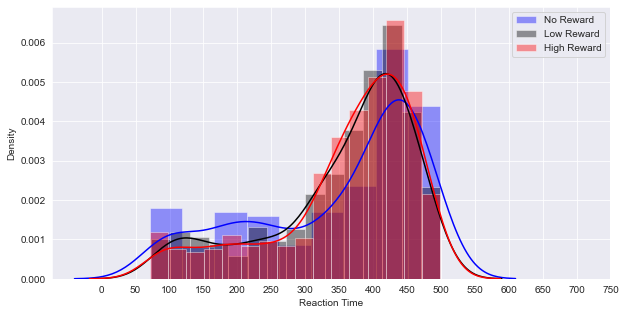

In [9]:
all_data = all_data[all_data["SRT"]>70]
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.distplot(all_data[all_data.reward=="No reward"]["SRT"],color="blue",label="No Reward")
sns.distplot(all_data[all_data.reward=="Low Reward"]["SRT"],color="black",label= "Low Reward")
sns.distplot(all_data[all_data.reward=="High Reward"]["SRT"],color="red", label= "High Reward")
plt.xticks(np.arange(0,800,50))
plt.xlabel("Reaction Time")
plt.legend()
plt.savefig('SRT.png',dpi=1200)
plt.show()


Duration:

/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

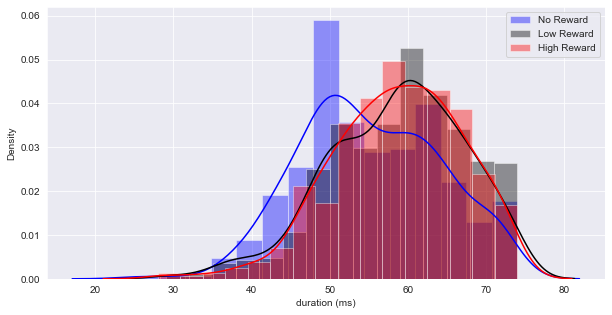

In [ ]:
#all_data1 = all_data[all_data["duration (ms)"]<=75]
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.distplot(all_data[all_data.reward=="No reward"]["duration (ms)"],color="blue",label="No Reward")
sns.distplot(all_data[all_data.reward=="Low Reward"]["duration (ms)"],color="black",label= "Low Reward")
sns.distplot(all_data[all_data.reward=="High Reward"]["duration (ms)"],color="red", label= "High Reward")
plt.legend()
plt.show()


Amplitude:

/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

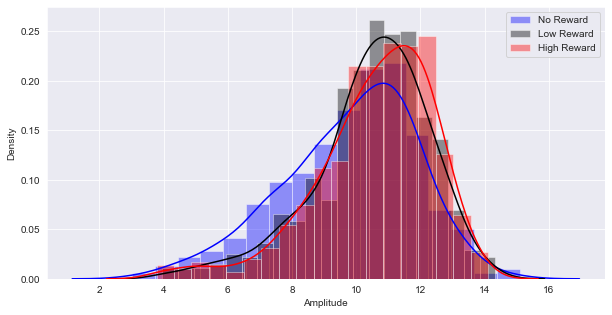

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,5))
sns.distplot(all_data[all_data.reward=="No reward"]["amplitude"],color="blue",label="No Reward")
sns.distplot(all_data[all_data.reward=="Low Reward"]["amplitude"],color="black",label= "Low Reward")
sns.distplot(all_data[all_data.reward=="High Reward"]["amplitude"],color="red", label= "High Reward")
plt.xlabel("Amplitude")
plt.legend()
plt.savefig('amplitude.png',dpi=600)
plt.show()


/Users/fatihdeniz/miniforge3/envs/streamlit/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 16.0, 'Type')

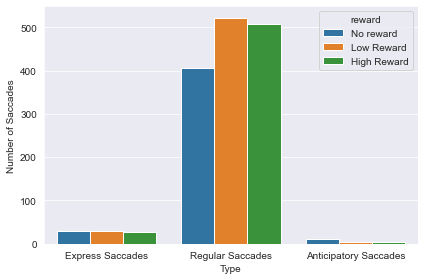

In [ ]:
ax = sns.countplot(all_data.type,hue=all_data.reward)
ax.set_xticklabels(["Express Saccades","Regular Saccades","Anticipatory Saccades"])
plt.tight_layout()
plt.ylabel("Number of Saccades")
plt.xlabel("Type")

**Violinplot with all individual points**

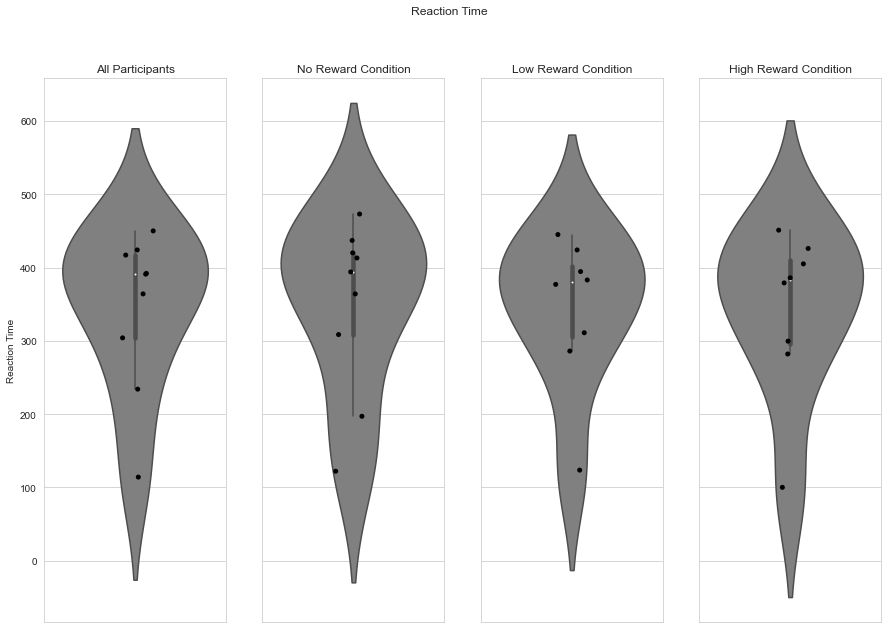

In [16]:
sns.set_style("whitegrid")
fig,axes = plt.subplots(1,4, figsize=(15,10),sharey=True)
fig.suptitle("Reaction Time")
sns.violinplot(ax=axes[0],y=all_data_preprocessed["median"],color="grey")
sns.stripplot(ax=axes[0],y=all_data_preprocessed["median"],color="black")
axes[0].set_ylabel("Reaction Time")
axes[0].set_title("All Participants")
sns.violinplot(ax=axes[1],y=all_data_preprocessed["mediansrtno"],color="grey")
sns.stripplot(ax=axes[1],y=all_data_preprocessed["mediansrtno"],color="black")
axes[1].set_ylabel(" ")
axes[1].set_title("No Reward Condition")
sns.violinplot(ax=axes[2],y=all_data_preprocessed["mediansrtlow"],color="grey")
sns.stripplot(ax=axes[2],y=all_data_preprocessed["mediansrtlow"],color="black")
axes[2].set_ylabel(" ")
axes[2].set_title("Low Reward Condition")
sns.violinplot(ax=axes[3],y=all_data_preprocessed["mediansrthigh"],color="grey")
sns.stripplot(ax=axes[3],y=all_data_preprocessed["mediansrthigh"],color="black")
axes[3].set_ylabel(" ")
axes[3].set_title("High Reward Condition")
plt.savefig('violin.png',dpi=1200)
